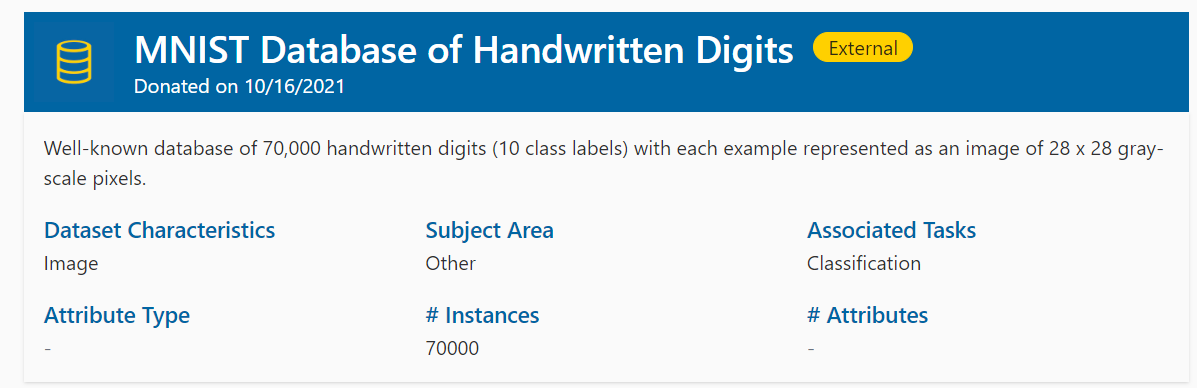


##  Data    
<a href="https://www.kaggle.com/datasets/hojjatk/mnist-dataset">Kaggle</a>
    

## Objectives

After completing this lab you will be able to:

* Use <a href="https://snapml.readthedocs.io/en/latest/decision_trees.html">IBM snapML</a> algorithms to classify


**For what purpose was the dataset created?**

As a testbed for development of handwriting recognition algorithms and machine learning classification algorithms in general.

**Who funded the creation of the dataset?**

The US National Institute of Standards and Technology (NIST) originally, and later, AT&T Bell Labs

**What do the instances in this dataset represent?**

28 x 28 gray-scale centered images of handwritten digites

**Are there recommended data splits?**

Yes. A specific split with 60,000 for training, 10,000 for testing.

**Was there any data preprocessing performed?**

The original NIST data was preprocessed by Yann LeCun and colleagues at AT&T Bell Labs: see http://yann.lecun.com/exdb/mnist/ for details

**Has the dataset been used for any tasks already?**

As a testbed for testing handwriten character recognition algorithms; and more generally for testing machine learning image classification methods


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#load_dataset">Load the  data</a></li>
        <li><a href="#modeling">Modeling</a></li>
        <li><a href="#evaluation">Evaluation</a></li>
        <li><a href="#practice">Practice</a></li>
    </ol>
</div>
<br>
<hr>


## import packages


In [1]:
#!pip install snapml

In [26]:
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
import scipy.optimize as opt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score
%matplotlib inline 
import matplotlib.pyplot as plt

# dealing with imbalance classes
from imblearn.over_sampling import SMOTE
from collections import Counter

import pickle # save the model

# suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data From CSV File  


In [3]:
mnist_train = pd.read_csv("mnist_train.csv")
mnist_test = pd.read_csv("mnist_test.csv")

In [4]:
# head of the training data
mnist_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# head of the test data
mnist_test.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Basic EDA

In [6]:
# check the columns
mnist_train.columns

Index(['label', '1x1', '1x2', '1x3', '1x4', '1x5', '1x6', '1x7', '1x8', '1x9',
       ...
       '28x19', '28x20', '28x21', '28x22', '28x23', '28x24', '28x25', '28x26',
       '28x27', '28x28'],
      dtype='object', length=785)

In [7]:
# data types
mnist_train.dtypes

label    int64
1x1      int64
1x2      int64
1x3      int64
1x4      int64
         ...  
28x24    int64
28x25    int64
28x26    int64
28x27    int64
28x28    int64
Length: 785, dtype: object

In [8]:
# missing values
mnist_train.isnull().any().sum()

0

## Data pre-processing and selection, Train/Test


In [9]:
# assign to the y variable
y_train = np.asarray(mnist_train['label'])
y_test = np.asarray(mnist_test['label'])

In [10]:
# assign the features
x_train = np.asarray(mnist_train.drop(columns='label'))
x_test = np.asarray(mnist_test.drop(columns='label'))

In [11]:
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (60000, 784) (60000,)
Test set: (10000, 784) (10000,)


## Feature scaling


In [12]:
scaler = StandardScaler() # scaler objecy
x_train = scaler.fit_transform(x_train) # allow the scaler object to learn the features and transform the training data
x_test =  scaler.transform(x_test) # apply the learned features on the test set

In [13]:
# scaled x_train
x_train[0:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
# scaled x_test
x_test[0:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<div id="svm_snap">
    <h2>Build a RandomForest model with Snap ML</h2>
</div>


In [15]:
%%time
# import the RandomForest from Snap ML
from snapml import RandomForestClassifier as SnapForest

# in contrast to scikit-learn's LinearSVC, Snap ML offers multi-threaded CPU/GPU training of RandomForest
# to use the GPU, set the use_gpu parameter to True
# rf = SnapForest(class_weight='balanced', random_state=25, use_gpu=True, fit_intercept=False)

# to set the number of threads used at training time, one needs to set the n_jobs parameter
rf = SnapForest(n_estimators=150, criterion='gini', 
                            max_depth=150, min_samples_leaf=1, 
                            max_features='auto', bootstrap=True, 
                            n_jobs=1, random_state=10, verbose=False, 
                            use_histograms=False, hist_nbins=256, 
                            use_gpu=False, gpu_ids=[0], 
                            compress_trees=False)

# train an SVM model using Snap ML
clf = rf.fit(x_train, y_train)

CPU times: total: 1min 57s
Wall time: 4min 6s


After being fitted, the model can then be used to predict new values:


In [16]:
yhat = clf.predict(x_test)
yhat[0:5]

array([7, 2, 1, 0, 4], dtype=int64)

In [35]:
Random_f1 = f1_score(y_test, yhat, average='weighted')
Random_accuracy = accuracy_score(y_test, yhat)
Random_precision = precision_score(y_test, yhat, average='micro')

print("Avg F1-score: %.4f" % Random_f1)
print("Accuracy: %.4f" % Random_accuracy)
print("Precision: %.4f" % Random_precision)

Avg F1-score: 0.9706
Accuracy: 0.9706
Precision: 0.9706


**Save the Random-Forest model:**

In [36]:
#save the trained model
pickle.dump(clf, open('Mnist-RF(SnapML).pkl','wb'))

<h2 id="evaluation">Evaluation</h2>


In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [38]:
# classification report
print (classification_report(y_test, yhat,labels=np.unique(yhat)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.97      0.96      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### **Report**

In [40]:
metric = {
  "Accuracy": [Random_f1],
  "F1 score" : [Random_accuracy],
  "Precision": [Random_precision]
}


Report = pd.DataFrame(metric)
Report = Report.rename(index={ 0:'Random Forest-SnapML'})

In [41]:
Report 

,Accuracy,F1 score,Precision
Random Forest-SnapML,0.970581,0.9706,0.9706


### **Now over to you TUNE the PARAMETERS to see if the ACCURACY and F1-SCORE will improve.**